In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import sys



In [2]:
# Import KRI Nowcasting csv
def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

nowcast_df = pd.read_csv("data/Nowcasting_Zahlen_200528.csv", sep=",") 
ck = nowcast_df.columns
# Renaming of columns
nowcast_df = nowcast_df.rename(columns={ck[0]:"date",ck[1]:"new_infected",ck[2]:"new_infected_low",ck[3]:"new_infected_high"})
nowcast_df = nowcast_df.rename(columns={ck[4]:"new_infected_smooth",ck[5]:"new_infected_smooth_low",ck[6]:"new_infected_smooth_high"})
nowcast_df = nowcast_df.rename(columns={ck[7]:"R_4",ck[8]:"R_4_low",ck[9]:"R_4_high"})
nowcast_df = nowcast_df.rename(columns={ck[10]:"R_7",ck[11]:"R_7_low",ck[12]:"R_7_high"})
# Generate proper timestamps
nowcast_df["date"] = nowcast_df["date"].apply(rdate)

print(nowcast_df.columns)

Index(['date', 'new_infected', 'new_infected_low', 'new_infected_high',
       'new_infected_smooth', 'new_infected_smooth_low',
       'new_infected_smooth_high', 'R_4', 'R_4_low', 'R_4_high', 'R_7',
       'R_7_low', 'R_7_high'],
      dtype='object')


# R from RKI definition

In [3]:
def RKI_R_old(infected_t,window=4):
    """ Calculate R value as published by the RKI on 2020-05-15
    in 'Erkäuterung der Schätzung der zeitlich variierenden Reproduktionszahl R'

    infected: Timeseries or trace, in general: last index is considered to calculate R
    window: averaging window, average over 4 days is default
    """
    r = np.zeros(infected_t.shape) # Empty array with the same shape as Timeseries
    
    if window == 1:
        r[...,4:] = infected_t[...,4:] / infected_t[...,:-4]
    elif window == 7:
        for i in range(10,infected_t.shape[-1]-1):
          # NOTE: R7_Wert[t-1] <- sum(data$NeuErk[t-0:6]) / sum(data&NeuErk[t-4:10]) 
          # Indexing in R (the stat-language) is inclusive, in numpy exclusive: upper boundary in sum is increased by 1
            r[...,i-1] = np.sum(infected_t[...,i-6:i+1],axis=infected_t.ndim-1) / np.sum(infected_t[...,i-10:i-3],axis=infected_t.ndim-1)
    else: # Default window = 4
        for i in range(7,infected_t.shape[-1]):
            r[...,i] = np.sum(infected_t[...,i-3:i+1],axis=infected_t.ndim-1) / np.sum(infected_t[...,i-7:i-3],axis=infected_t.ndim-1)
    
    # mask of R_values that were not calculated to match time-index of output to input
    return np.ma.masked_where((r == 0) | np.isinf(r) | np.isnan(r),r)


def RKI_R(infected_t, window=4, gd=4):
    """ Calculate R value as published by the RKI on 2020-05-15
    in 'Erkäuterung der Schätzung der zeitlich variierenden Reproduktionszahl R'

    infected: Timeseries or trace, in general: last index is considered to calculate R
    window: averaging window, average over 4 days is default
    """
    r = np.zeros(infected_t.shape)  # Empty array with the same shape as Timeseries

    if window == 1:
        r[..., gd:] = infected_t[..., gd:] / infected_t[..., :-gd]
    else:
        if window == 7:
            offset = 1
        elif window == 4:
            offset = 0

        for t in range(window + gd, infected_t.shape[-1] - offset):
            # NOTE: R7_Wert[t-1] <- sum(data$NeuErk[t-0:6]) / sum(data&NeuErk[t-4:10])
            # Indexing in R (the stat-language) is inclusive, in numpy exclusive: upper boundary in sum is increased by 1

            right_block = infected_t[..., t - window : t]
            left_block = infected_t[..., t - window - gd : t - gd]

            r[..., t - 1 - offset] = np.sum(right_block, axis=-1) / np.sum(left_block, axis=-1)

    # mask of R_values that were not calculated to match time-index of output to input
    return np.ma.masked_where((r == 0) | np.isinf(r) | np.isnan(r), r)

(3, 83) (3, 83)
{'rki_1day': (datetime.date(2020, 3, 19), 0.9980948348856901, 1.1908704408144999), 'rki_4days': (datetime.date(2020, 3, 21), 0.9674295774647887, 1.0488376835236541), 'rki_7days': (datetime.date(2020, 3, 22), 0.9751447738088412, 1.0322905259419304)}


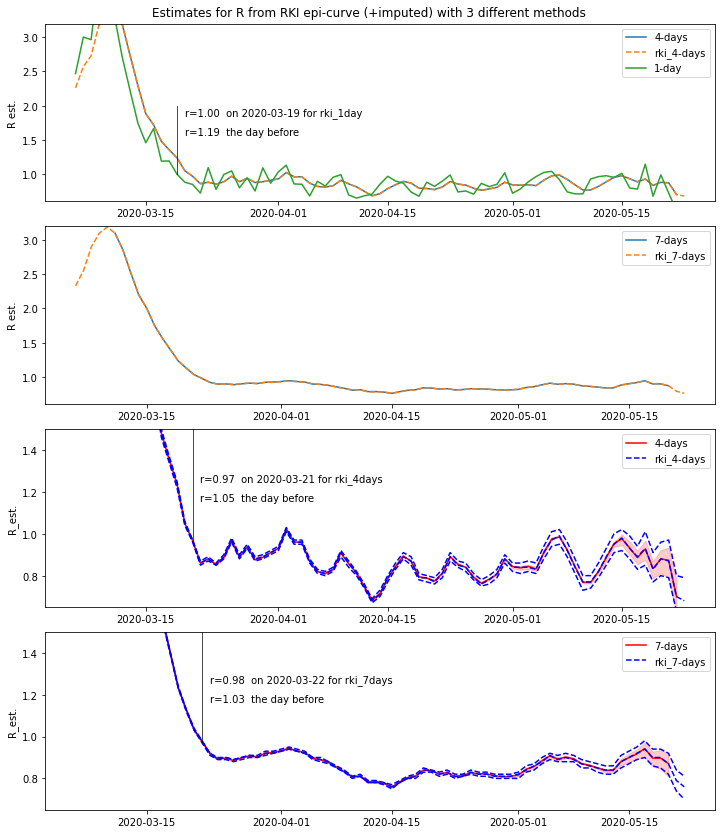

In [4]:
# Retriece from RKI .csv as plain numpy arrays
# Onsets - use the unfiltered onsets
onsets = nowcast_df["new_infected"].to_numpy(dtype=np.float64)
onsets_low = nowcast_df["new_infected_low"].to_numpy(dtype=np.float64)
onsets_high = nowcast_df["new_infected_high"].to_numpy(dtype=np.float64)
# RKI R-estimates
r_rki4 = nowcast_df["R_4"].to_numpy(dtype=np.float64)
r_rki4_low = nowcast_df["R_4_low"].to_numpy(dtype=np.float64)
r_rki4_high = nowcast_df["R_4_high"].to_numpy(dtype=np.float64)
r_rki7 = nowcast_df["R_7"].to_numpy(dtype=np.float64)
r_rki7_low = nowcast_df["R_7_low"].to_numpy(dtype=np.float64)
r_rki7_high = nowcast_df["R_7_high"].to_numpy(dtype=np.float64)

# - - - Plot stuff - - -
fig, axes = plt.subplots(4, 1, figsize = (10,12),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for R from RKI epi-curve (+imputed) with 3 different methods')

# Plot the 4-day window average to compare RKI with this implementation
ax = axes[0,0]
ax.plot(nowcast_df["date"],RKI_R(onsets,4),label="4-days")
ax.plot(nowcast_df["date"],r_rki4,"--",label="rki_4-days")
ax.plot(nowcast_df["date"],RKI_R(onsets,1),label="1-day")

ax.set_ylim(.6,3.2)
ax.legend()
ax.set_ylabel("R est.")

# Plot the 7-day window average to compare RKI with this implementation
bx = axes[1,0]
bx.plot(nowcast_df["date"],RKI_R(onsets,7),label="7-days")
bx.plot(nowcast_df["date"],r_rki7,"--",label="rki_7-days")

bx.set_ylim(.6,3.2)
bx.legend()
bx.set_ylabel("R est.")

# Timeseries Trace-like as Matrix
onsets_trace = np.array([onsets_low,onsets,onsets_high])
my_rki4 = RKI_R(onsets_trace,4)
my_rki7 = RKI_R(onsets_trace,7)
print(onsets_trace.shape,my_rki4.shape)

# Plot the 4-day window average to compare with 95% levels by RKI
cx = axes[2,0]
cx.plot(nowcast_df["date"],my_rki4[1],label="4-days",color="red")
cx.fill_between(nowcast_df["date"],my_rki4[0],my_rki4[2],alpha=.2,color="red")
cx.plot(nowcast_df["date"],r_rki4,"--",color="blue",label="rki_4-days")
cx.plot(nowcast_df["date"],r_rki4_low,"--",color="blue")
cx.plot(nowcast_df["date"],r_rki4_high,"--",color="blue")
cx.set_ylim(.65,1.5)
cx.legend()
cx.set_ylabel("R_est.")

# Plot the 7-day window average to compare with 95% levels by RKI
dx = axes[3,0]
dx.plot(nowcast_df["date"],my_rki7[1],label="7-days",color="red")
dx.fill_between(nowcast_df["date"],my_rki7[0],my_rki7[2],alpha=.2,color="red")
dx.plot(nowcast_df["date"],r_rki7,"--",color="blue",label="rki_7-days")
dx.plot(nowcast_df["date"],r_rki7_low,"--",color="blue")
dx.plot(nowcast_df["date"],r_rki7_high,"--",color="blue")
dx.set_ylim(.65,1.5)
dx.legend()
dx.set_ylabel("R_est.")

# Add annotation for all three variants: 1day,4day,7day
below1 = {}
test_below = {"rki_1day":(RKI_R(onsets,1),ax),"rki_4days":(my_rki4[1],cx),"rki_7days":(my_rki7[1],dx)}
for k,values in test_below.items():
    d,tx = values
    r2 = 10
    for t,r in zip(nowcast_df["date"],d):
        if r < 1:
            break
        r2 = r
        
    below1[k] = (t,r,r2)
    tx.plot([t]*2,[r,r+1],color="black",linewidth=.7)
    offset = (tx.get_ylim()[1]-tx.get_ylim()[0])/9
    tx.text(t+datetime.timedelta(days=1),r+offset*3,"r=%.2f  on %s for %s"%(r,t,k))
    tx.text(t+datetime.timedelta(days=1),r+offset*2,"r=%.2f  the day before"%(r2))

print(below1)